# Principle Component analysis of crowdfunding projects
Data visualization of Kickstarter projects based on suitable visualization techniques including a principal component analysis (PCA).

The dataset was downloaded from
https://www.kaggle.com/kemical/kickstarter-projects 
on September 14th 2018.

In [5]:
# Run this cell first to apply the style to the notebook
from IPython.core.display import HTML
css_file = './31380.css'
HTML(open(css_file, "r").read())

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
%matplotlib inline

In [2]:
# create the dataframe and define a reduced version with the first 
# 5000 observations of project goal and the total amount pledged
raw_data = pd.read_csv('ks-projects-201801.csv')
cols = ['goal', 'pledged']
df = pd.DataFrame(raw_data, columns = cols)
df_training = df[0:5000] # real training set: df[0:250000]
# df_testing = df[250000:]

# compute (reduced) dataframe dimensions (X = N x M)
N = len(df['goal'])
M = len(cols)

FileNotFoundError: File b'ks-projects-201801.csv' does not exist

In [ ]:
# Now we need to filter the data for errors

# We don't care about the ID or name columns
# (we assume that it doesn't matter if a project
# is missing a name or ID, or if the name or
# ID of the project is strange/missing). We'll take
# these out later.

# Now for the categories. Let's view them:
cat = raw_data.loc[:,'category']
if cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cat_sort = sorted(set(cat))
    print(cat_sort)

In [ ]:
# We inspect the cat_sort vector and don't
# find any mistakes/errors.

# We'll use 1-of-K encoding. Declare the attribute
# categorical with pandas
raw_data['category'] = pd.Categorical(raw_data['category'])

# 1-of-K and combine w/ raw data
cat_Dummies = pd.get_dummies(raw_data['category'], prefix = 'category')
raw_data = pd.concat([raw_data, cat_Dummies], axis=1)

In [ ]:
# Now for the main categories. Let's view them:
main_cat = raw_data.loc[:,'main_category']
if main_cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    main_cat_sort = sorted(set(main_cat))
    print(main_cat_sort)

In [ ]:
# No mistakes/errors. 1-of-K encoding. Declare categorical
raw_data['main_category'] = pd.Categorical(raw_data['main_category'])

# 1-of-K and combine w/ raw data
main_cat_Dummies = pd.get_dummies(raw_data['main_category'], prefix = 'main_cat')
raw_data = pd.concat([raw_data, main_cat_Dummies], axis=1)

In [ ]:
# Now for currencies. Let's view them:
cur = raw_data.loc[:,'currency']
if cur.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cur_sort = sorted(set(cur))
    print(cur_sort)

In [ ]:
# No mistakes/errors. Declare categorical
raw_data['currency'] = pd.Categorical(raw_data['currency'])

# 1-of-K and combine w/ raw data
cur_Dummies = pd.get_dummies(raw_data['currency'], prefix = 'currency')
raw_data = pd.concat([raw_data, cur_Dummies], axis=1)

In [ ]:
# As far as the dates go, we'd like to exclude projects that started
# before April of 2009 and projects that ended after September of 2018
# (we only want to look at finished projects)

raw_data['launched'] = pd.to_datetime(raw_data['launched'])
raw_data['deadline'] = pd.to_datetime(raw_data['deadline'])
len(raw_data[raw_data['launched'] < datetime.date(2009,4,1)])

# There are 7 observations that started before Kickstarter's founding month.
# These are removed:
raw_data = raw_data[raw_data['launched'] >= datetime.date(2009,4,1)]

In [ ]:
# Now check deadline dates:
len(raw_data[raw_data['deadline'] > datetime.date(2018,9,20)])

# There aren't any observations finishing after the start of our
# work on this project, so we won't remove any.

In [ ]:
# Now check dates for missing values
if raw_data.launched.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
if raw_data.deadline.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

In [ ]:
# Now we'd like to go from "launched" and "deadline"
# to "duration" (in days) and "yearlaunched"

# Year launched 
raw_data['yearlaunched'] = pd.DatetimeIndex(raw_data['launched']).year

# Make a new coloum with the new duration
raw_data['duration']=(raw_data['deadline']-raw_data['launched']).astype('timedelta64[h]')/24

In [ ]:
# Kickstarter projects used to have a max duration of 90 days (now 60 days).
# Therefore we'd like to cut the projects that have a duration of over 90 days.
len(raw_data[raw_data['duration'] > 90])

# There are 457 such projects. Let's take these out.
raw_data = raw_data[raw_data['duration'] < 90]

In [ ]:
# Now for the states. Let's view them:
states = raw_data['state']
if states.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_sort = sorted(set(states))
    print(states_sort)

# We inspect the states_sort vector and don't
# find any mistakes/errors. We do, however, have canceled, failed, suspended,
# undefined, and live projects.

In [ ]:
# Let's start by inspecting at the undefined.
undefined = raw_data[states == 'undefined']
print(undefined)

In [ ]:
# Seems like most of the undefined are in main categories "Music",
# "Publishing" or "Film & Video":
(len(undefined[undefined['main_category'] == 'Music'])+len(undefined[undefined['main_category'] == 'Publishing'])+len(undefined[undefined['main_category'] == 'Film & Video']))/len(undefined)

# 99.7 percent of undefined projects were in these categories. But based on
# what we're doing, we can't really use undefined projects for anything, so
# we'll take these rows out.
raw_data = raw_data[raw_data['state'] != 'undefined']
len(raw_data[raw_data['state'] == 'undefined']) == 0

In [ ]:
# Let's inspect the paused projects.
len(raw_data[states == 'suspended'])

# There are about 1800 of these. We'll take them out as well, since they don't
# help us.
raw_data = raw_data[raw_data['state'] != 'suspended']
len(raw_data[raw_data['state'] == 'suspended']) == 0

In [ ]:
# Now for canceled projects:
len(raw_data[states == 'canceled'])

# About 10% of projects in the data set have been canceled. Let's keep these
# in and see if the algorithm can guess which projects will be canceled.

In [ ]:
# Now for live projects:
len(raw_data[states == 'live'])

# There are about 2800 of these. The data was pulled in January 2018, so
# let's see what that means in terms of end dates.
live = raw_data[raw_data['state'] == 'live'].sort_values(by = 'deadline')

In [ ]:
# The first 7 examples are mistakes of some sort. Let's see what's up:
live.iloc[0:7,:]['usd_pledged_real']
live.iloc[0:7,:]['usd_goal_real']
live.iloc[0:7,:]['usd_pledged_real'] - live.iloc[0:7,:]['usd_goal_real']

In [ ]:
# Its seems that all these projects actually failed. Let's change their status
notlive = live.iloc[0:7,:]
for i in range(len(notlive)):
    notlive.at[i,9] = 'failed'

In [ ]:
# Update original dataframe and check
raw_data.update(notlive)
len(raw_data[raw_data['deadline'] < datetime.date(2018,1,1)][raw_data['state'] == 'live']) == 0

# Delete rest of the live values and check
raw_data = raw_data[raw_data['state'] != 'live']
len(raw_data[raw_data['state'] == 'live']) == 0

In [ ]:
# Let's view states again
states_1 = raw_data.loc[:,'state']
if states_1.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_1_sort = sorted(set(states_1))
    print(states_1_sort)

In [ ]:
# No mistakes/errors. Declare categorical
raw_data['state'] = pd.Categorical(raw_data['state'])

# 1-of-K and combine w/ raw data
state_Dummies = pd.get_dummies(raw_data['state'], prefix = 'state')
raw_data = pd.concat([raw_data, state_Dummies], axis=1)

In [ ]:
# Let's look at backers. Check for missing values
if raw_data.backers.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

In [ ]:
# There are missing values. Let's inspect them:
raw_data[raw_data.backers.isnull()]

# I don't really know what to do with these, but I'd rather not
# delete them. Let's see what the average
# amount pledged to backer ratio is.

raw_data.ratio = raw_data.usd_pledged_real[raw_data.backers > 0] / raw_data.backers[raw_data.backers > 0]
avg_ratio = sum(raw_data.ratio[raw_data.ratio.notnull()]/len(raw_data.ratio[raw_data.ratio.notnull()]))
print(avg_ratio)

In [ ]:
# Let's replace NaN values using this ratio. But, if there is 0 USD pledged, set backers to 0
nullbackers = raw_data[raw_data.backers.isnull()]
nullbackers.loc[nullbackers['usd_pledged_real'] == 0, 'backers'] = 0
nullbackers.backers = round(nullbackers.usd_pledged_real/avg_ratio)

In [ ]:
# Put back into dataframe
raw_data.update(nullbackers)

# The type is float64, let's convert this to int
raw_data.backers = raw_data.backers.astype(int)

In [ ]:
# Now for the countries. Let's view them:
countries = raw_data.country
if countries.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    countries_sort = sorted(set(countries))
    print(countries_sort)

In [ ]:
# 'N,0"' is clearly a mistake.
raw_data.country[raw_data.country == 'N,0"']

In [ ]:
# For whatever reason there are 233 of these observations. No clue what that
# means. Let's check currency for these observations
raw_data.currency[raw_data.country == 'N,0"']

In [ ]:
# All sorts of different currencies. Let's check more generally.
raw_data[raw_data.country == 'N,0"'].sort_values(by = 'usd_pledged_real')

In [ ]:
# Let's not delete these values. At least one of these projects seem significant
# (there's one with over 2.7 mio USD pledged).

# 1-of-K encoding. Declare categorical
raw_data.country = pd.Categorical(raw_data.country)

# 1-of-K and combine w/ raw data
country_Dummies = pd.get_dummies(raw_data.country, prefix = 'country')
raw_data = pd.concat([raw_data, country_Dummies], axis=1)

In [ ]:
# We only want to use usd_pledged_real and usd_goal_real, so we'll delete
# everything else. Now we'll also delete the ID and name columns, and the
# categorical variables that we've 1-of-K encoded.

# First let's check usd_pledged_real and usd_goal_real. Check for missing values:
pledged = raw_data.usd_pledged_real
if pledged.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
goal = raw_data.usd_goal_real
if goal.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

In [ ]:
# Check for negatives:
len(raw_data[raw_data['usd_pledged_real'] < 0])
len(raw_data[raw_data['usd_goal_real'] < 0])

In [ ]:
# Fine. Fetch the new column names:
col1 = raw_data.columns.values

# Switch backers with usd_pledged_real (from https://stackoverflow.com/
# questions/25649429/how-to-swap-two-dataframe-columns)
col1[10], col1[12] = col1[12], col1[10]

# assign back, the order will now be swapped
raw_data.columns = col1
raw_data.columns.values

In [ ]:
# Now let's take the important part of the data
raw_data = raw_data.iloc[:,12:]

# Check one last time for missing data
raw_data.isnull().sum().sum()

# PCA analysis should now be possible

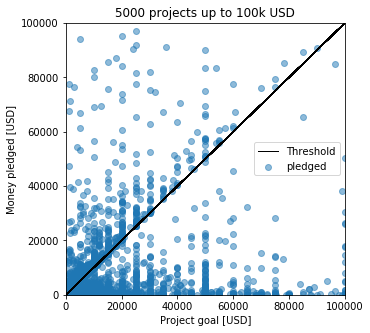

In [68]:
# plot a simple relationship
fig, ax = plt.subplots(figsize=(5,5))
ax.set(title='5000 projects up to 100k USD',
      xlabel='Project goal [USD]', ylabel='Money pledged [USD]',
      xlim=[0, 100000], ylim=[0, 100000])
ax.scatter(df_training['goal'], df_training['pledged'], alpha=0.5)
ax.plot(df_training['goal'], df_training['goal'], color='black', linewidth=1, label='Threshold')
ax.legend()
# idea: split dataset
success_mask = [df_training['pledged'] >= df_training['goal']]
# 'succeeded'-color blue, else 'failed'-red 

In [ ]:
# Subtract mean value from data
Y = X - X.mean(axis=0)

# PCA by computing SVD of Y
U,S,V = svd(Y,full_matrices=False)
# print('U[0] = ', U[0], '\nS[0] =', S[0], '\nV[0] =', V[0])

# Compute variance explained by principal components
rho = (S**2) / (S**2).sum()

# Plot variance explained
fig, ax = plt.subplots(ncols=2)
ax1.plot(range(1,len(rho)+1),rho,'o-')
ax1.set(title='Variance explained by principal components', 
        xlabel='Principal component', ylabel='Variance explained')

It is possible to use standard LaTeX code to visualize formulas nicely:

$$y+2x^2 = 2\pi$$

$$\sum\limits_{x=1}^{\infty} {1 \over x} = 2$$